# Locality Measure Pearson
We want to summarize, how local the covariance is, e.g. how big is the radius around a pixel so the accumulated covariance is below 95%? For this task, we define a covariance matrix $\Sigma$, with a constant variance on the diagonals, while the covariance decreases exponentially in all directions on a regular grid.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg as la
import ipywidgets as widgets

In [19]:
def exponential(value, gamma):
    return np.exp( - gamma * value)

def linear(value, gamma):
    return - gamma * value + 1

def get_neigbours_y(p, n, height, width):
    '''
    Get the neighbouring indices of the pixel p along the y-axis within 
    distance n.

    Parameter
    ---------
    p: [int]
        Index of the target pixel.
    n: int
        Distance at whitch the neighbours are considered.
    height: int
        Height of the grid.
    width: int
        Width of the grid.

    Return
    ------
    [int]
        A list of neighbouring indices in ascending order.
    '''

    assert p >= 0, 'The index of the pixel should be poitive or zero' 
    assert (height > 0 or width > 0), 'The height and width should be positive numbers'

    if n < 1:
        return []

    neighbours = []
    # move upwards
    for i in range(1, n+1):
        if p - i * width < 0:
            break
        neighbours.append(p - i * width)

    # ensure ascending order
    neighbours.reverse()

    # move downwards
    for i in range(1, n+1):
        if p + i * width >= width*height:
            break
        neighbours.append(p + i * width)

    return neighbours

def build_covariance_y(variance, function, width=3):
    '''
    Generate a covariance matrix, which covariance is along the 
    y-dimension of a grid.

    Parameter
    ---------
    variance: array_like
        A 2D array of variances for each pixel.
    '''
    
    im_height, im_width = variance.shape
    n = im_height * im_width
    var = np.diagflat(variance.flatten())
    
    for p in range(n):
        idy = get_neigbours_y(p, width, im_height, im_width)
        
        omega = np.arange(0,width+1)
        rho = function(omega, 1/width)
        
        top = 1
        bottom = min(width, p//im_width)
        for idx in idy:
            if p < idx:
                # bottom
                #var[p,idx] = np.sqrt(var[p,p]) * np.sqrt(var[idx,idx]) * rho[top]
                var[idx,p] = np.sqrt(var[p,p]) * np.sqrt(var[idx,idx]) * rho[top]
                top += 1
            if p > idx:
            #    # top
                var[idx,p] = np.sqrt(var[p,p]) * np.sqrt(var[idx,idx]) * rho[bottom]
            #    var[p,idx] = np.sqrt(var[p,p]) * np.sqrt(var[idx,idx]) * bottom
                bottom -= 1
            
    return var

def build_covariance_matrix(variance, function, width=3):
    n = variance.shape[0]
    var = np.diag(variance.flatten())
    
    distance_map = [
        np.eye(n*n)
    ]
    
    if width > 1:
        # connect each row
        tpRow = np.zeros((n,1), dtype=np.float32)
        tpRow[1] = 1
        offdi = la.toeplitz(tpRow)
        # connect each column
        tpEdge = np.zeros((n,1), dtype=np.float32)
        tpEdge[0] = 1
        offedge = la.toeplitz(tpEdge)
        #connect diagonals
        tpDiag = np.zeros((n,1), dtype=np.float32)
        tpDiag[1] = 1
        offdiag = la.toeplitz(tpDiag)

        I = np.eye(n, dtype=np.float32)
        Ileft = np.roll(I, 1, axis=0) + np.roll(I, -1, axis=0)
        Ileft[0,n-1] = 0
        Ileft[n-1,0] = 0

        A = np.kron(I, offdi) + np.kron(Ileft, offedge)  + np.kron(Ileft, offdiag)
        A *= function(1, 1/np.log(width))
        
        distance_map.append(A)
        
    for weight in range(2, width):
        A_depth = distance_map[-1] @ distance_map[1]
        A_depth[ A_depth > 0 ] = 1.0
        for A_prev in distance_map:
            A_depth[ A_prev > 0 ] = 0.0
        
        A_depth *= function(weight, 1/width)
            
        distance_map.append(A_depth)

        
    # enforce positive semi-definite
    R = np.sum(distance_map, axis=0)
    #R = R @ R.T
    #R /= R.max()
    covariance = var @ R @ var
    
    return covariance

In [4]:
def dist_covariance(Rho, idx, percent=0.95, precision=3, debug=False):
    n = np.int64(np.sqrt(Rho.shape[0]))
    rho_i = Rho[idx, :].reshape((n,n))
    
    pixel = np.array([
        idx % n,
        idx // n
    ])
    
    overallCovariance = rho_i.sum()
    condition = round(percent * overallCovariance, precision)
    
    if rho_i[pixel[1], pixel[0]] > percent * overallCovariance:
        return 0
    
    width = np.max(rho_i.shape) + 1
    for i in range(1, width):
        left = max(0, pixel[0]-i)
        right = min(rho_i.shape[0], pixel[0]+i+1)
        top = max(0, pixel[1]-i)
        bottom = min(rho_i.shape[1], pixel[1]+i+1)

        subset = rho_i[top:bottom, left:right]
        subset_sum = round(subset.sum(), precision)
        
        if debug:
            print(subset)
            mapping = np.zeros_like(Sigma_i)
            mapping[top:bottom, left:right] = 1
            print(subset_sum, condition)
            plt.figure()
            plt.suptitle('{:d} - {:f} > {:f}'.format(i, subset_sum, condition))
            plt.subplot(1,2,1)
            plt.imshow(mapping)
            ax = plt.gca()
            ax.set_xticks(np.arange(-.5, n, 1))
            ax.set_yticks(np.arange(-.5, n, 1))
            ax.set_xticklabels(np.arange(0, n+1, 1))
            ax.set_yticklabels(np.arange(0, n+1, 1))
            ax.grid(color='red', linestyle='-.', linewidth=1)

            plt.subplot(1,2,2)
            plt.imshow(subset)
            plt.colorbar()

            plt.show()
        
        if subset_sum > condition:
            # the subset contains now more that `percent` of the overall covariance,
            # thus the previus is below that thresshold
            return i - 1

        if right == rho_i.shape[0] and bottom == rho_i.shape[1] and left == 0 and top == 0:
            # maximum reached
            return i
    return width

def to_pearson(Sigma):
    variances = np.sqrt(np.diag(Sigma))
    
    # divide through the neigbouring variances and then through the own variance
    Sigma_hat = (Sigma / variances).T / variances
    
    return Sigma_hat

#Rho = to_pearson(Sigma_hat)
#p = np.array([5, 6])
#targetPixel = p[1] * gridDimensions[0] + p[0]
#dist_covariance(Rho, targetPixel, 0.52, debug=False)

#p = np.array([4, 6])
#targetPixel = p[1] * gridDimensions[0] + p[0]
#dist_covariance(Rho, targetPixel, 0.52, debug=False)

# Covariance with linear decay
We now consider a covariance $\Sigma$, which is homogene in its variance $\sigma^2$ and its covariance structure $\Sigma$ on a regular grid.

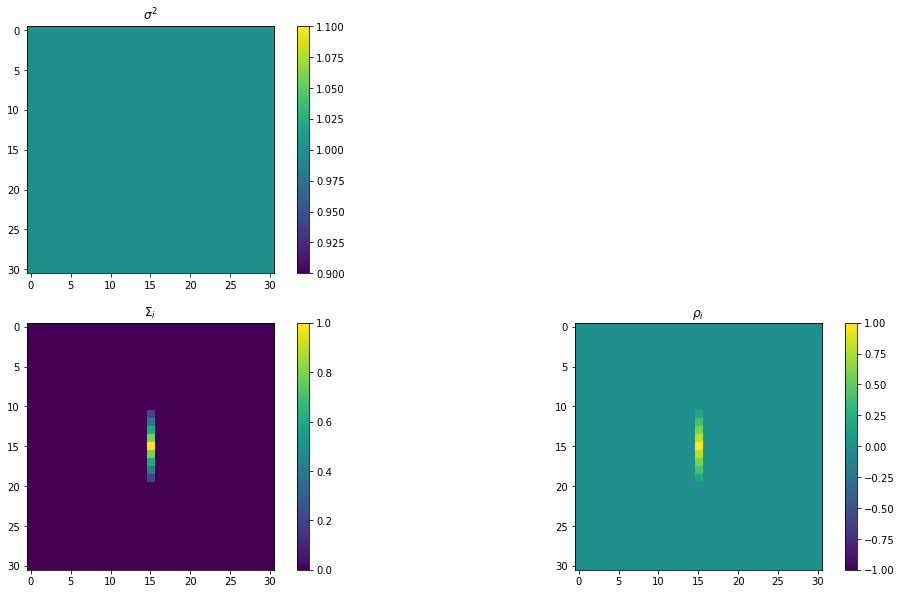

In [68]:
gridDimensions = np.array([31,31])
variance = np.ones(gridDimensions)

Sigma = build_covariance_y(variance, linear, 5)

# center pixel
p = np.array([gridDimensions[0]//2, gridDimensions[1]//2])
targetPixel = p[1] * gridDimensions[0] + p[0]
Sigma_i = Sigma[targetPixel,:].reshape(gridDimensions)

variances = np.sqrt(np.diag(Sigma))
sigma_x = variances[targetPixel]
# get only the correlated variances
covariances = Sigma_i.flatten()
rho_i = np.array([covariances[idx] / (sigma_x * sigma_y) for idx,sigma_y in enumerate(variances)]).reshape(gridDimensions)

plt.figure(figsize=(18,10))
plt.subplot(2,2,1)
plt.imshow(variances.reshape(gridDimensions))
plt.title(r'$\sigma^2$')
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(Sigma_i)
plt.title(r'$\Sigma_i$')
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(rho_i, vmin=-1, vmax=1)
plt.title(r'$\rho_i$')
plt.colorbar()
plt.show()

# Inject some variations in the magnitude

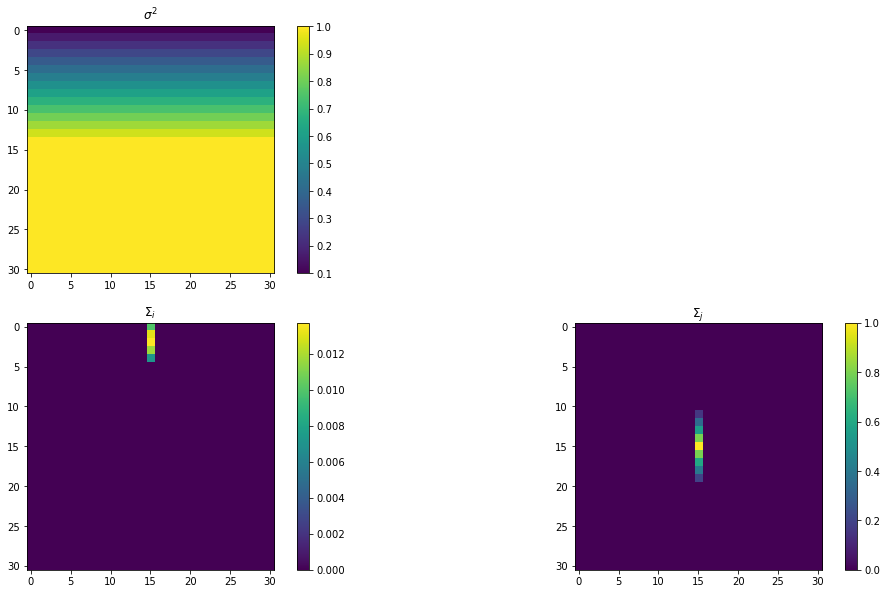

In [69]:
scaling = np.linspace(0.1, 1, gridDimensions[1]//2)

Sigma_hat = Sigma.copy()
for x in range(gridDimensions[0]):
    for y in range(gridDimensions[0]//2):
        idx = y * gridDimensions[0] + x
        Sigma_hat[idx,:] *= scaling[y]
        Sigma_hat[:,idx] *= scaling[y]

p = np.array([gridDimensions[0]//2, 0])
targetPixel = p[1] * gridDimensions[0] + p[0]
Sigma_i = Sigma_hat[targetPixel,:].reshape(gridDimensions)

p = np.array([gridDimensions[0]//2, 15])
targetPixel = p[1] * gridDimensions[0] + p[0]
Sigma_j = Sigma_hat[targetPixel,:].reshape(gridDimensions)

variances = np.sqrt(np.diag(Sigma_hat))

plt.figure(figsize=(18,10))
plt.subplot(2,2,1)
plt.imshow(variances.reshape(gridDimensions))
plt.title(r'$\sigma^2$')
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(Sigma_i)
plt.title(r'$\Sigma_i$')
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(Sigma_j)
plt.title(r'$\Sigma_j$')
plt.colorbar()
plt.show()

In [70]:
Rho = to_pearson(Sigma_hat)
@widgets.interact(percent=(0.01, 0.99, 0.01))
def show_locality(percent=0.01):
    localityMap = np.array([dist_covariance(Rho, p, percent) for p in range(Sigma.shape[0])]).reshape(gridDimensions)

    plt.figure(figsize=(18,6))
    plt.imshow(localityMap)
    plt.colorbar()
    plt.show()

interactive(children=(FloatSlider(value=0.01, description='percent', max=0.99, min=0.01, step=0.01), Output())…

In [71]:
num = 100
overview = np.zeros((*gridDimensions, num))

for idx,percent in enumerate(np.linspace(0.01, 0.99, num)):
    overview[:,:,idx] = np.array([dist_covariance(Rho, p, percent) for p in range(Sigma.shape[0])]).reshape(gridDimensions)

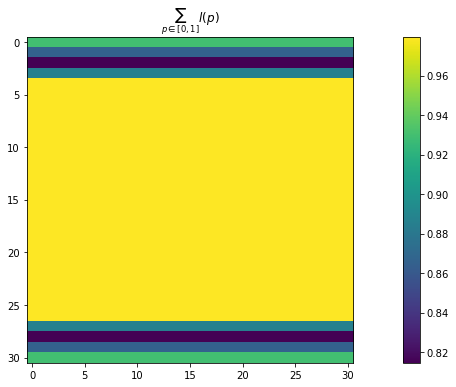

In [72]:
plt.figure(figsize=(18,6))
plt.title(r'$\sum_{p \in [0,1]} l(p)$')
plt.imshow(np.std(overview, axis=2))
plt.colorbar()
plt.show()

# Inject some variations in width of the structure

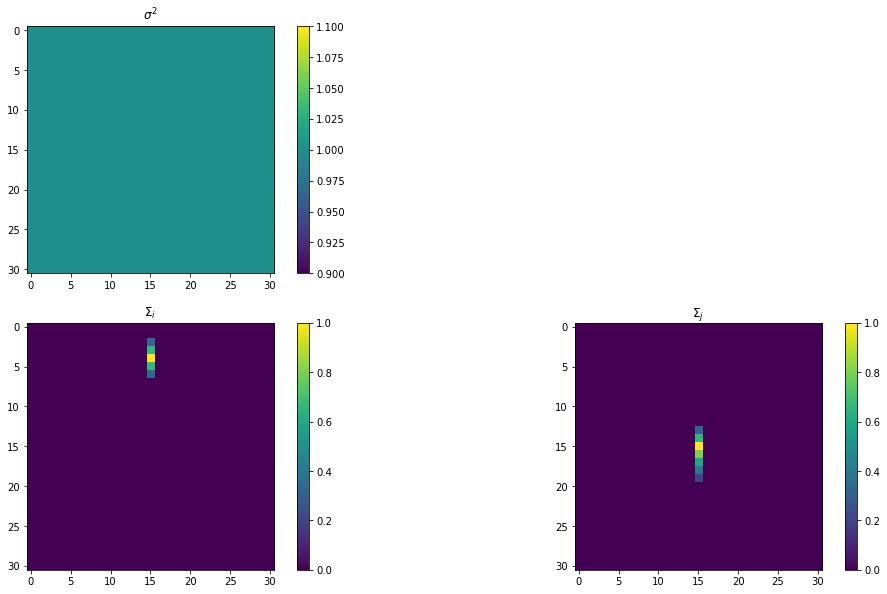

In [73]:
new_structure = build_covariance_y(variance, linear, 3)

Sigma_hat = Sigma.copy()
for x in range(gridDimensions[0]):
    for y in range(gridDimensions[0]//2):
        idx = y * gridDimensions[0] + x
        Sigma_hat[idx,:] = new_structure[idx,:]
        Sigma_hat[:,idx] = new_structure[:,idx]

p = np.array([gridDimensions[0]//2, 4])
targetPixel = p[1] * gridDimensions[0] + p[0]
Sigma_i = Sigma_hat[targetPixel,:].reshape(gridDimensions)

p = np.array([gridDimensions[0]//2, 15])
targetPixel = p[1] * gridDimensions[0] + p[0]
Sigma_j = Sigma_hat[targetPixel,:].reshape(gridDimensions)

variances = np.sqrt(np.diag(Sigma_hat))

plt.figure(figsize=(18,10))
plt.subplot(2,2,1)
plt.imshow(variances.reshape(gridDimensions))
plt.title(r'$\sigma^2$')
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(Sigma_i)
plt.title(r'$\Sigma_i$')
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(Sigma_j)
plt.title(r'$\Sigma_j$')
plt.colorbar()
plt.show()

In [74]:
Rho = to_pearson(Sigma_hat)
@widgets.interact(percent=(0.01, 0.99, 0.01))
def show_locality(percent=0.01):
    localityMap = np.array([dist_covariance(Rho, p, percent) for p in range(Sigma.shape[0])]).reshape(gridDimensions)

    plt.figure(figsize=(18,6))
    plt.imshow(localityMap)
    plt.colorbar()
    plt.show()

interactive(children=(FloatSlider(value=0.01, description='percent', max=0.99, min=0.01, step=0.01), Output())…

In [75]:
num = 100
overview = np.zeros((*gridDimensions, num))

for idx,percent in enumerate(np.linspace(0.01, 0.99, num)):
    overview[:,:,idx] = np.array([dist_covariance(Rho, p, percent) for p in range(Sigma.shape[0])]).reshape(gridDimensions)

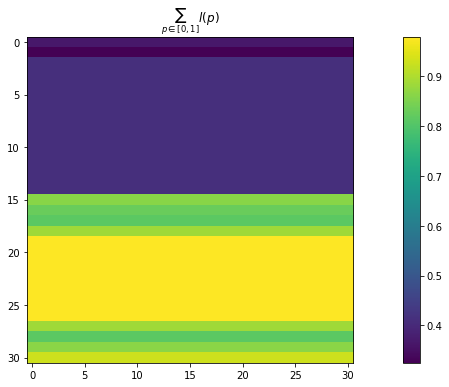

In [76]:
plt.figure(figsize=(18,6))
plt.title(r'$\sum_{p \in [0,1]} l(p)$')
plt.imshow(np.std(overview, axis=2))
plt.colorbar()
plt.show()

# Inject some variations in the dirstribution of the structure

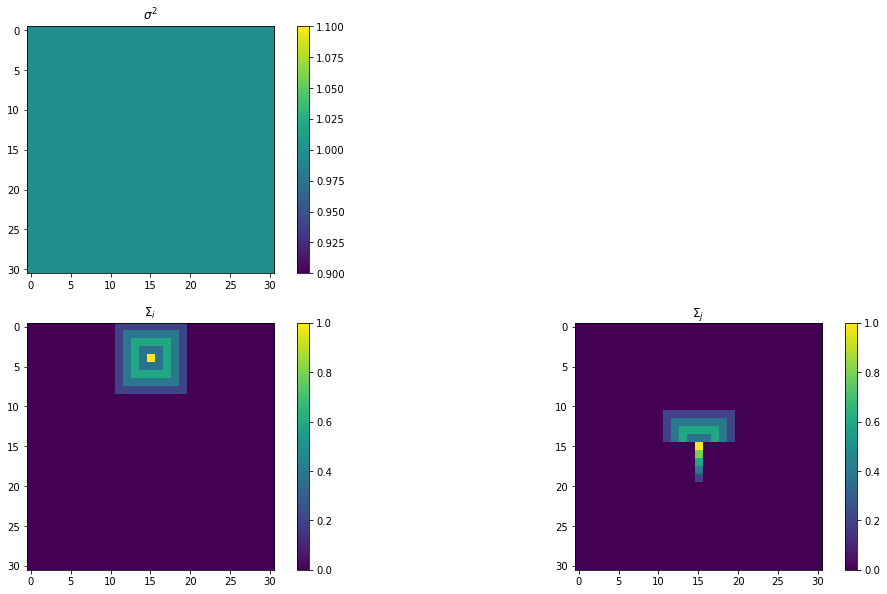

In [77]:
new_structure = build_covariance_matrix(variance, linear, 5)

Sigma_hat = Sigma.copy()
for x in range(gridDimensions[0]):
    for y in range(gridDimensions[0]//2):
        idx = y * gridDimensions[0] + x
        Sigma_hat[idx,:] = new_structure[idx,:]
        Sigma_hat[:,idx] = new_structure[:,idx]

p = np.array([gridDimensions[0]//2, 4])
targetPixel = p[1] * gridDimensions[0] + p[0]
Sigma_i = Sigma_hat[targetPixel,:].reshape(gridDimensions)

p = np.array([gridDimensions[0]//2, 15])
targetPixel = p[1] * gridDimensions[0] + p[0]
Sigma_j = Sigma_hat[targetPixel,:].reshape(gridDimensions)

variances = np.sqrt(np.diag(Sigma_hat))

plt.figure(figsize=(18,10))
plt.subplot(2,2,1)
plt.imshow(variances.reshape(gridDimensions))
plt.title(r'$\sigma^2$')
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(Sigma_i)
plt.title(r'$\Sigma_i$')
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(Sigma_j)
plt.title(r'$\Sigma_j$')
plt.colorbar()
plt.show()

In [78]:
Rho = to_pearson(Sigma_hat)
@widgets.interact(percent=(0.01, 0.99, 0.01))
def show_locality(percent=0.01):
    localityMap = np.array([dist_covariance(Rho, p, percent) for p in range(Sigma.shape[0])]).reshape(gridDimensions)

    plt.figure(figsize=(18,6))
    plt.imshow(localityMap)
    plt.colorbar()
    plt.show()

interactive(children=(FloatSlider(value=0.01, description='percent', max=0.99, min=0.01, step=0.01), Output())…

In [79]:
num = 100
overview = np.zeros((*gridDimensions, num))

for idx,percent in enumerate(np.linspace(0.01, 0.99, num)):
    overview[:,:,idx] = np.array([dist_covariance(Rho, p, percent) for p in range(Sigma.shape[0])]).reshape(gridDimensions)

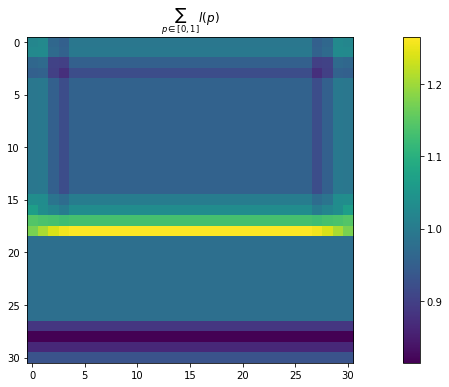

In [80]:
plt.figure(figsize=(18,6))
plt.title(r'$\sum_{p \in [0,1]} l(p)$')
plt.imshow(np.std(overview, axis=2))
plt.colorbar()
plt.show()

# Using experimental data

In [47]:
Sigma_radon = np.load('../../Data/iradon/Sigma_w10_p5_cosine.npy')
Rho_radon = to_pearson(Sigma_radon)
gridDimensions = np.array([64,64])

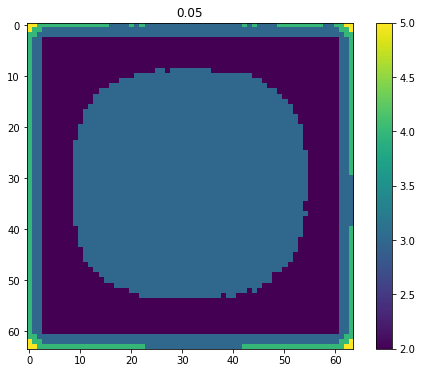

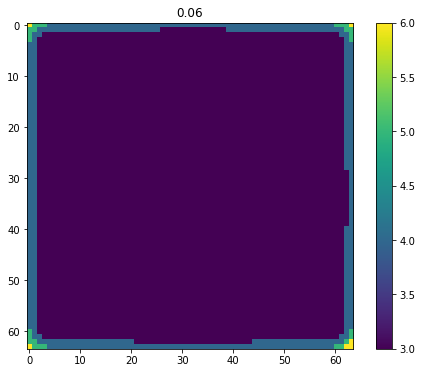

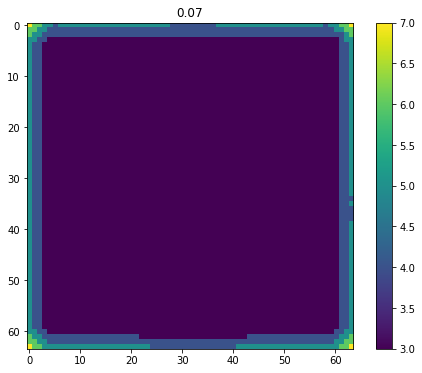

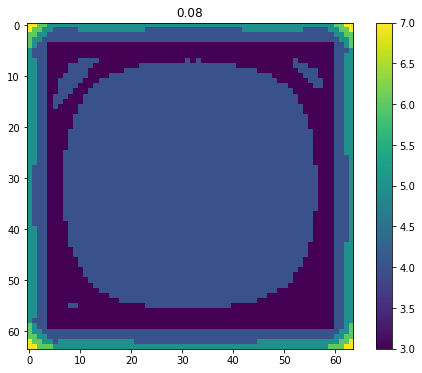

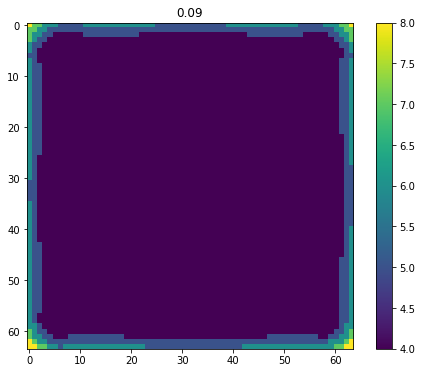

In [154]:
for percent in np.arange(0.05, 0.1, 0.01):
    localityMap = np.array([dist_covariance(Rho_radon, p, percent) for p in range(Sigma_radon.shape[0])]).reshape(gridDimensions)

    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1)
    plt.title('{:g}'.format(percent))
    plt.imshow(localityMap)
    plt.colorbar()
    plt.show()

# Statistical methods
Now let $O = \{l(p_i), 1\% \leq p_i \leq 25\%\}$ be a set of localities for different percentage cuts $1\% \leq p_i \leq 25\%$.

In [61]:
num = 25
overview = np.zeros((*gridDimensions, num))

for idx,percent in enumerate(np.linspace(0.01, 0.25, num)):
    overview[:,:,idx] = np.array([dist_covariance(Rho_radon, p, percent) for p in range(Sigma_radon.shape[0])]).reshape(gridDimensions)

# Sum

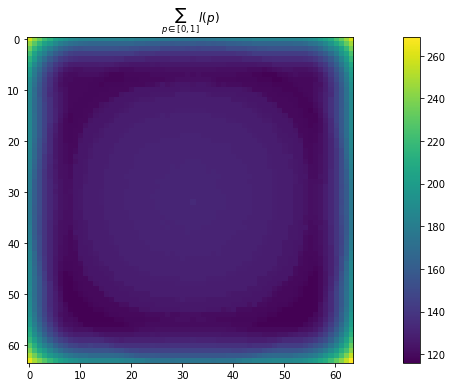

In [62]:
plt.figure(figsize=(18,6))
plt.title(r'$\sum_{p \in [0,1]} l(p)$')
plt.imshow(np.sum(overview, axis=2))
plt.colorbar()
plt.show()

# Mean

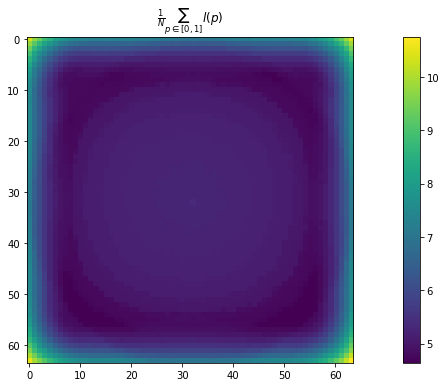

In [63]:
plt.figure(figsize=(18,6))
plt.title(r'$\frac{1}{N}\sum_{p \in [0,1]} l(p)$')
plt.imshow(np.mean(overview, axis=2))
plt.colorbar()
plt.show()

# Variance

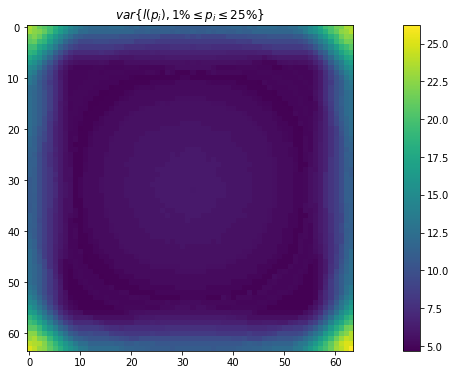

In [64]:
plt.figure(figsize=(18,6))
plt.title(r'$var \{l(p_i), 1\% \leq p_i \leq 25\%\}$')
plt.imshow(np.var(overview, axis=2))
plt.colorbar()
plt.show()

# Standard deviation

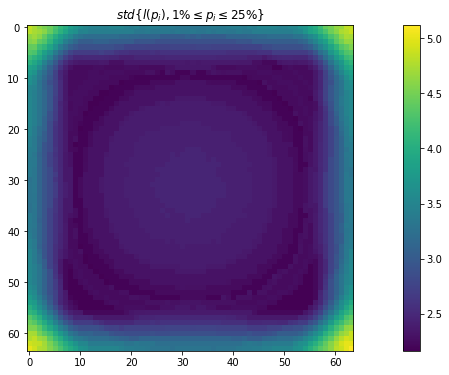

In [65]:
plt.figure(figsize=(18,6))
plt.title(r'$std \{l(p_i), 1\% \leq p_i \leq 25\%\}$')
plt.imshow(np.std(overview, axis=2))
plt.colorbar()
plt.show()

# Range

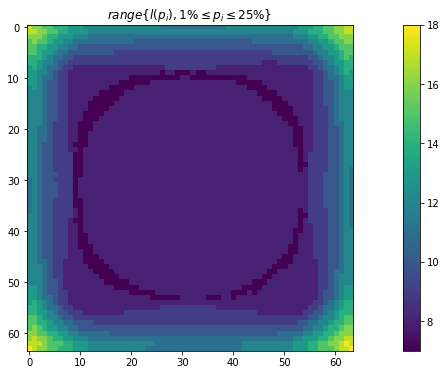

In [66]:
plt.figure(figsize=(18,6))
plt.title(r'$range \{l(p_i), 1\% \leq p_i \leq 25\%\}$')
plt.imshow(np.max(overview, axis=2) - np.min(overview, axis=2))
plt.colorbar()
plt.show()

# Median

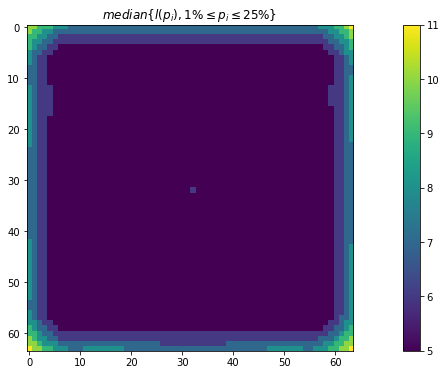

In [67]:
plt.figure(figsize=(18,6))
plt.title(r'$median \{l(p_i), 1\% \leq p_i \leq 25\%\}$')
plt.imshow(np.median(overview, axis=2))
plt.colorbar()
plt.show()